In [32]:
import numpy as np
import matplotlib.pyplot as plt

import pykitti
from scipy.spatial.transform import Rotation as R

import io
import contextlib
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.figure import Figure


In [33]:
%load_ext autoreload
%autoreload 2
import EM_KalmanFilter
import LinearKF2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Dataset

In [34]:
basedir = '/Users/DiptiVM1/Documents/GT COURSEWORK/CS6476/Project'
date = '2011_09_26'
drive = '0001'  

dataset = pykitti.raw(basedir, date, drive)

In [35]:
oxts = dataset.oxts
timestamps = dataset.timestamps
N = len(oxts)

In [36]:
# Compute dt per step
dt_list = [(timestamps[i+1] - timestamps[i]).total_seconds()
           for i in range(N-1)]
dt_list = np.array(dt_list)
dt_mean = np.mean(dt_list)

In [37]:
gps_std = np.array([1.0, 1.0])  # 1 m STD in x,y

In [38]:
import numpy as np
from scipy.spatial.transform import Rotation as R
np.random.seed(42)

pkt0 = oxts[0].packet
T0 = oxts[0].T_w_imu
R_w_imu_0 = T0[0:3, 0:3]

# Initial Position
p0 = T0[0:3, 3]
p0_xy = p0[:2]

# Initial Velocity
v_body_0 = np.array([pkt0.vf, pkt0.vl, pkt0.vu]) 
v0_world = R_w_imu_0 @ v_body_0
v0_xy = v0_world[:2]

# Initialize Yaw (for rotating acceleration only)
r0 = R.from_matrix(R_w_imu_0)
roll0, pitch0, yaw0 = r0.as_euler('xyz', degrees=False)
yaw_est = yaw0 

acceleration_imu = []  
sensor_updates = []    
positions_gt = []     
velocity_gt = []       

for k in range(N-1):
    dt = dt_list[k]
    o = oxts[k]
    o_next = oxts[k+1]
    packet = o.packet
    packet_next = o_next.packet 

    # 1) Propagate yaw outside state (for rotating accel)
    omega_z = packet.wz
    yaw_est = yaw_est + omega_z * dt
    a_body_xy = np.array([packet.ax, packet.ay]) 
    
    cy = np.cos(yaw_est)
    sy = np.sin(yaw_est)
    R_yaw = np.array([[cy, -sy],
                      [sy,  cy]])

    a_world_xy = R_yaw @ a_body_xy 
    acceleration_imu.append(a_world_xy)

    # Ground Truths
    T_gt = o_next.T_w_imu
    p_gt = T_gt[0:3, 3]
    p_gt_xy = p_gt[0:2]
    
    R_w_imu = T_gt[0:3, 0:3]
    v_body_next = np.array([packet_next.vf, packet_next.vl, packet_next.vu])       
    v_world_next = R_w_imu @ v_body_next
    v_gt_xy = v_world_next[0:2]

    positions_gt.append(p_gt_xy)
    velocity_gt.append(v_gt_xy)

    # Synthetic GPS Measurement
    noise = np.random.randn(2) * gps_std
    z_gps_xy = p_gt_xy + noise 
    sensor_updates.append(z_gps_xy)

acceleration_imu = np.array(acceleration_imu) 
sensor_updates = np.array(sensor_updates)     
positions_gt = np.array(positions_gt)         
velocity_gt = np.array(velocity_gt)          

# append initial position and velocity to GT for plotting
positions_gt = np.vstack([p0_xy, positions_gt])
velocity_gt = np.vstack([v0_xy, velocity_gt])

In [39]:
from EM_KalmanFilter import EM_KalmanFilter 
from LinearKF2D import LinearKF2D

np.random.seed(42)

pkt0 = oxts[0].packet
T0 = oxts[0].T_w_imu
R_w_imu = T0[0:3, 0:3]

# velocities: body frame to world frame
v_body = np.array([pkt0.vf, pkt0.vl, pkt0.vu])  

v0_world = R_w_imu @ v_body    
v0_xy = v0_world[:2]

p0 = T0[0:3, 3]
p0_xy = p0[:2]


# KF and EM Initialization
kf = LinearKF2D(process_var=1.0, meas_var=1.0) 
em_kf = EM_KalmanFilter(kf_class=kf, max_iter=30)

# print(p0_xy.shape)
# print(v0_xy.shape)
# print(sensor_updates.shape)

smooth_mus, smooth_covs, Q_hist, R_hist = em_kf.fit(
    measurements=sensor_updates, 
    dt_list=dt_list, 
    accel_inputs=acceleration_imu,
    p0=p0_xy,
    v0=v0_xy
)

filtered_mus = em_kf.filtered_mus
filtered_covs = em_kf.filtered_covs

(107, 4)
(107, 4, 4)
new_R:  0.9578681148483172
sse_meas:  188.0467587465635
accel_bias:  [0. 0.]
new_Q:  0.6676342211418437
sse_process:  7.927411781092019
Iter 1: Q_est=0.6676, R_est=0.9579
(107, 4)
(107, 4, 4)
new_R:  0.9594265557056755
sse_meas:  189.0067583146961
accel_bias:  [0. 0.]
new_Q:  0.6661989491365947
sse_process:  7.0461547698691165
Iter 2: Q_est=0.6662, R_est=0.9594
(107, 4)
(107, 4, 4)
new_R:  0.9594351231882241
sse_meas:  189.01203588394606
accel_bias:  [0. 0.]
new_Q:  0.6661925420970547
sse_process:  7.04222084759156
Iter 3: Q_est=0.6662, R_est=0.9594
(107, 4)
(107, 4, 4)
new_R:  0.9594351614872904
sse_meas:  189.0120594761708
accel_bias:  [0. 0.]
new_Q:  0.666192513487166
sse_process:  7.04220328111998
Iter 4: Q_est=0.6662, R_est=0.9594
(107, 4)
(107, 4, 4)
new_R:  0.9594351616583112
sse_meas:  189.01205958151974
accel_bias:  [0. 0.]
new_Q:  0.6661925133594119
sse_process:  7.042203202678859
Iter 5: Q_est=0.6662, R_est=0.9594
(107, 4)
(107, 4, 4)
new_R:  0.959435161

In [40]:
sigma_x_list = []  
sigma_y_list = []  

### Plot and save to PDF 

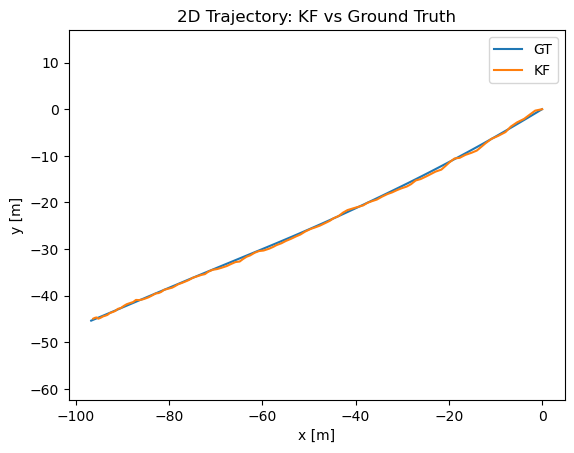

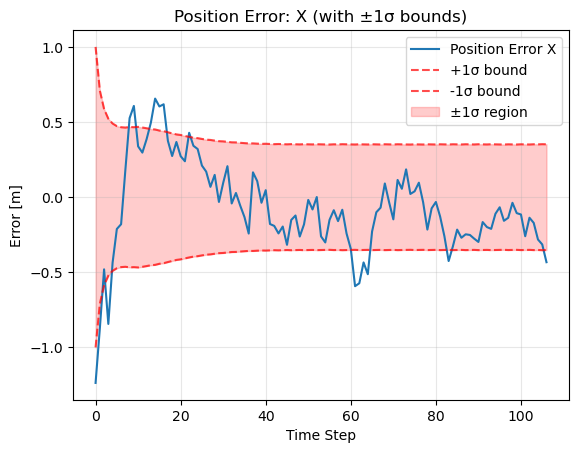

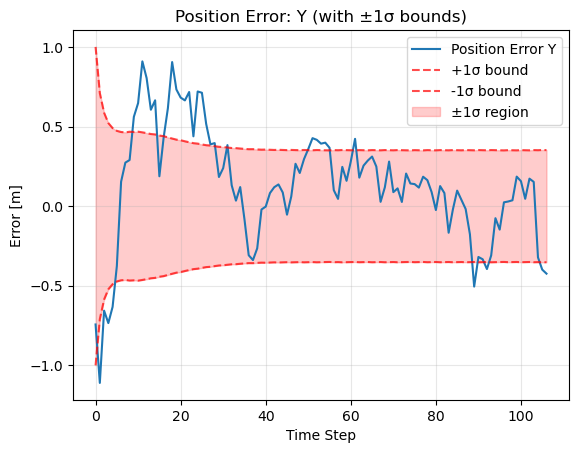

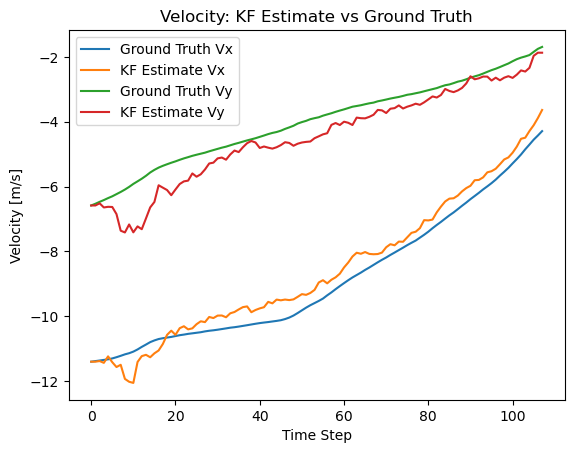

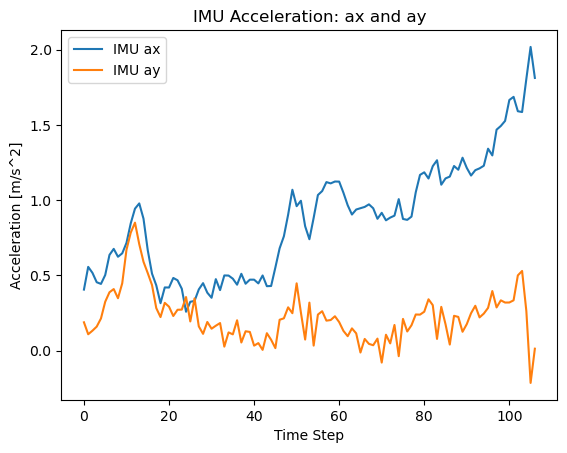

RMSE:  0.4977983291581423
Percentage of errors within ±1σ: X=85.0%, Y=68.2%
  X error - Mean: -0.0734 m, Std: 0.3082 m, Max: 1.2365 m
  Y error - Mean: 0.1320 m, Std: 0.3606 m, Max: 1.1103 m
  X - Filter σ (mean): 0.3850 m
  Y - Filter σ (mean): 0.3850 m
  X bias: -0.0734 m
  Y bias: 0.1320 m



In [41]:

pdf_filename = f"kf_results_pvar{kf.process_var}_mvar{kf.meas_var}_EM_strongpriorQ_strongpriorM_start1_30iter_targetQ1_Pscale1.pdf"

positions_kf = np.vstack([p0_xy, filtered_mus[:,0:2]])
velocity_kf = np.vstack([v0_xy, filtered_mus[:,2:4]])

sigma_x_list = np.sqrt(filtered_covs[:,0,0])
sigma_y_list = np.sqrt(filtered_covs[:,1,1])


figures_for_pdf = []
log_stream = io.StringIO()
with contextlib.redirect_stdout(log_stream):

    # Trajectory (GT vs KF)
    fig = plt.figure()
    plt.plot(positions_gt[:,0], positions_gt[:,1], label='GT')
    plt.plot(positions_kf[:,0], positions_kf[:,1], label='KF')
    plt.axis('equal')
    plt.legend()
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title('2D Trajectory: KF vs Ground Truth')
    plt.show()
    figures_for_pdf.append(fig)

    # position errors (GT - KF) 
    error_x = positions_gt[1:,0] - positions_kf[1:,0]
    error_y = positions_gt[1:,1] - positions_kf[1:,1]

    sigma_x_arr = np.array(sigma_x_list)
    sigma_y_arr = np.array(sigma_y_list)

    sse = np.sum(error_x**2+error_y**2)
    mse = sse/len(error_x)
    rmse = np.sqrt(mse)
    print("RMSE: ", rmse)

    fig = plt.figure()
    plt.plot(error_x, label='Position Error X', linewidth=1.5)
    plt.plot(sigma_x_arr, 'r--', label='+1σ bound', alpha=0.7)
    plt.plot(-sigma_x_arr, 'r--', label='-1σ bound', alpha=0.7)
    plt.fill_between(range(len(error_x)), -sigma_x_arr, sigma_x_arr, alpha=0.2, color='red', label='±1σ region')
    plt.xlabel('Time Step')
    plt.ylabel('Error [m]')
    plt.title('Position Error: X (with ±1σ bounds)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    figures_for_pdf.append(fig)

    fig = plt.figure()
    plt.plot(error_y, label='Position Error Y', linewidth=1.5)
    plt.plot(sigma_y_arr, 'r--', label='+1σ bound', alpha=0.7)
    plt.plot(-sigma_y_arr, 'r--', label='-1σ bound', alpha=0.7)
    plt.fill_between(range(len(error_y)), -sigma_y_arr, sigma_y_arr, alpha=0.2, color='red', label='±1σ region')
    plt.xlabel('Time Step')
    plt.ylabel('Error [m]')
    plt.title('Position Error: Y (with ±1σ bounds)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    figures_for_pdf.append(fig)


    within_1sigma_x = np.sum(np.abs(error_x) <= sigma_x_arr) / len(error_x) * 100
    within_1sigma_y = np.sum(np.abs(error_y) <= sigma_y_arr) / len(error_y) * 100
    print(f"Percentage of errors within ±1σ: X={within_1sigma_x:.1f}%, Y={within_1sigma_y:.1f}%")

    print(f"  X error - Mean: {np.mean(error_x):.4f} m, Std: {np.std(error_x):.4f} m, Max: {np.max(np.abs(error_x)):.4f} m")
    print(f"  Y error - Mean: {np.mean(error_y):.4f} m, Std: {np.std(error_y):.4f} m, Max: {np.max(np.abs(error_y)):.4f} m")

    print(f"  X - Filter σ (mean): {np.mean(sigma_x_arr):.4f} m")
    print(f"  Y - Filter σ (mean): {np.mean(sigma_y_arr):.4f} m")

    print(f"  X bias: {np.mean(error_x):.4f} m")
    print(f"  Y bias: {np.mean(error_y):.4f} m")

    velocity_kf_arr = np.vstack(velocity_kf)    
    velocity_gt_arr = np.vstack(velocity_gt)    
    fig = plt.figure()
    plt.plot(velocity_gt_arr[:,0], label='Ground Truth Vx')
    plt.plot(velocity_kf_arr[:,0], label='KF Estimate Vx')
    plt.plot(velocity_gt_arr[:,1], label='Ground Truth Vy')
    plt.plot(velocity_kf_arr[:,1], label='KF Estimate Vy')
    plt.xlabel('Time Step')
    plt.ylabel('Velocity [m/s]')
    plt.title('Velocity: KF Estimate vs Ground Truth')
    plt.legend()
    plt.show()
    figures_for_pdf.append(fig)

    acc_imu_arr = np.vstack(acceleration_imu)  
    fig = plt.figure()
    plt.plot(acc_imu_arr[:,0], label='IMU ax')
    plt.plot(acc_imu_arr[:,1], label='IMU ay')
    plt.xlabel('Time Step')
    plt.ylabel('Acceleration [m/s^2]')
    plt.title('IMU Acceleration: ax and ay')
    plt.legend()
    plt.show()
    figures_for_pdf.append(fig)

# Save to PDF
from matplotlib.backends.backend_pdf import PdfPages

stats_text = log_stream.getvalue()
print(stats_text)

with PdfPages(pdf_filename) as pdf:
    for fig in figures_for_pdf:
        pdf.savefig(fig)
        plt.close(fig)

    stats_fig = Figure(figsize=(8.5, 11))
    ax = stats_fig.subplots()
    ax.axis('off')
    lines = stats_text.split('\n')
    wrapped_lines = []
    import textwrap
    for line in lines:
        wrapped_lines.extend(textwrap.wrap(line, 100))
    ax.text(0.01, 0.99, "\n".join(wrapped_lines), fontsize=9, va='top', family='monospace')
    pdf.savefig(stats_fig)

